### Imports:

In [ ]:
!pip install hdbscan
!pip install sentence-transformers
!pip install umap-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

from hdbscan import HDBSCAN
from sklearn import metrics


from sentence_transformers import SentenceTransformer
import umap

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os

In [4]:
from transformers import BertTokenizer, BertModel

### Loading Data:

In [15]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# train = pd.read_csv("data/train.csv")
# test = pd.read_csv("data/test.csv")
train_test = pd.concat([train, test], ignore_index=True)

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [17]:
def get_sentence_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Apply the function to each utterance
test['BERT_embeddings'] = test['text'].apply(get_sentence_embeddings)
test

,text,category,BERT_embeddings
0,How do I locate my card?,card_arrival,"[0.11946717, 0.046251476, 0.07216136, -0.07174..."
1,"I still have not received my new card, I order...",card_arrival,"[0.14556515, -0.1730164, 0.3964176, 0.20625204..."
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[-0.050331566, -0.2557019, 0.4459546, -0.03042..."
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.04474088, -0.36700767, 0.41925097, 0.03467..."
4,My card has not arrived yet.,card_arrival,"[0.30289167, -0.22428101, 0.10192654, -0.20357..."
...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.49874625, -0.04689104, 0.43037686, -0.37731..."
3076,How many countries do you support?,country_support,"[0.41691935, -0.19576646, 0.10277992, -0.10128..."
3077,What countries do you do business in?,country_support,"[0.43335468, -0.14970161, -0.07299836, -0.2744..."
3078,What are the countries you operate in.,country_support,"[0.26136366, -0.20304795, -0.15264174, -0.1744..."


In [23]:
bert_embeddings = np.vstack(test['BERT_embeddings'].to_numpy())

umap_embeddings = umap.UMAP(n_neighbors=10, n_components=5, metric='cosine').fit_transform(bert_embeddings)

In [55]:
hdbscan = HDBSCAN(min_cluster_size=18)
test["topic"] = hdbscan.fit_predict(umap_embeddings)
test

,text,category,BERT_embeddings,topic
0,How do I locate my card?,card_arrival,"[0.11946717, 0.046251476, 0.07216136, -0.07174...",9
1,"I still have not received my new card, I order...",card_arrival,"[0.14556515, -0.1730164, 0.3964176, 0.20625204...",-1
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[-0.050331566, -0.2557019, 0.4459546, -0.03042...",-1
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.04474088, -0.36700767, 0.41925097, 0.03467...",9
4,My card has not arrived yet.,card_arrival,"[0.30289167, -0.22428101, 0.10192654, -0.20357...",-1
...,...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.49874625, -0.04689104, 0.43037686, -0.37731...",8
3076,How many countries do you support?,country_support,"[0.41691935, -0.19576646, 0.10277992, -0.10128...",9
3077,What countries do you do business in?,country_support,"[0.43335468, -0.14970161, -0.07299836, -0.2744...",9
3078,What are the countries you operate in.,country_support,"[0.26136366, -0.20304795, -0.15264174, -0.1744...",9


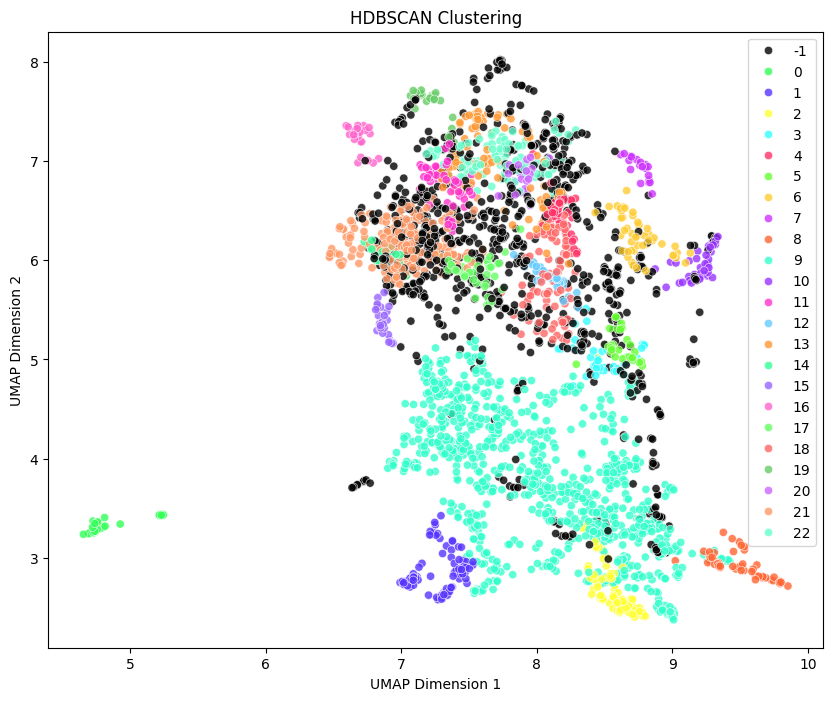

In [53]:
custom_colors = [
    '#000000', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF',
    '#FF3366', '#66FF33', '#FFCC33', '#CC33FF',
    '#FF6633', '#33FFCC', '#9933FF', '#FF33CC', '#66CCFF',
    '#FF9933', '#33FF99', '#9966FF', '#FF66CC', '#66FF66',
    '#FF6666', '#66CC66', '#CC66FF', '#FF9966', '#66FFCC', '#FFCC66'
]
custom_palette = sns.color_palette(custom_colors)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=test["topic"], legend='full', alpha=0.8, palette=custom_palette)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

### For each cluster, output the unique categories in that cluster, and their respective count:

In [79]:
cluster_info = {}
for i in np.unique(hdbscan.labels_):
  rah = test[test["topic"]== i]
  value_counts = rah["category"].value_counts()

  category_info = {}
  for index, count in value_counts.items():
    category_info[index] = count

  cluster_info[i] = category_info

cluster_info

{-1: {'lost_or_stolen_phone': 31,
  'card_arrival': 31,
  'request_refund': 29,
  'beneficiary_not_allowed': 28,
  'card_swallowed': 24,
  'declined_card_payment': 24,
  'lost_or_stolen_card': 23,
  'why_verify_identity': 21,
  'card_payment_not_recognised': 20,
  'cash_withdrawal_not_recognised': 20,
  'activate_my_card': 20,
  'declined_cash_withdrawal': 19,
  'Refund_not_showing_up': 18,
  'declined_transfer': 18,
  'wrong_amount_of_cash_received': 18,
  'topping_up_by_card': 17,
  'extra_charge_on_statement': 17,
  'cancel_transfer': 17,
  'contactless_not_working': 17,
  'reverted_card_payment?': 17,
  'direct_debit_payment_not_recognised': 17,
  'transfer_not_received_by_recipient': 15,
  'balance_not_updated_after_cheque_or_cash_deposit': 14,
  'failed_transfer': 14,
  'transfer_into_account': 14,
  'verify_top_up': 13,
  'pending_transfer': 13,
  'top_up_failed': 13,
  'balance_not_updated_after_bank_transfer': 13,
  'pending_cash_withdrawal': 13,
  'card_delivery_estimate': 12